# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.5 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.5 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    #subs = min(nchords, subsamples) if subsamples is not None else None
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    alpha_h = pyro.param('alpha_h', torch.ones(nharmonies, device=device), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', torch.ones(npcs, device=device), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    #subs = min(nchords, subsamples) if subsamples is not None else None
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [10]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [11]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [12]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [13]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [14]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)
        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [15]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [16]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [17]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  1%|          | 3/350 [00:05<08:09,  1.41s/it]

Step 0 : loss = 3438914.873247265


 30%|██▉       | 104/350 [00:11<00:11, 20.91it/s]

Step 100 : loss = 2523088.058095717


 59%|█████▊    | 205/350 [00:14<00:04, 32.06it/s]

Step 200 : loss = 2266339.225686624


 87%|████████▋ | 303/350 [00:18<00:01, 30.79it/s]

Step 300 : loss = 2068930.8437874394


100%|██████████| 350/350 [00:19<00:00, 17.77it/s]


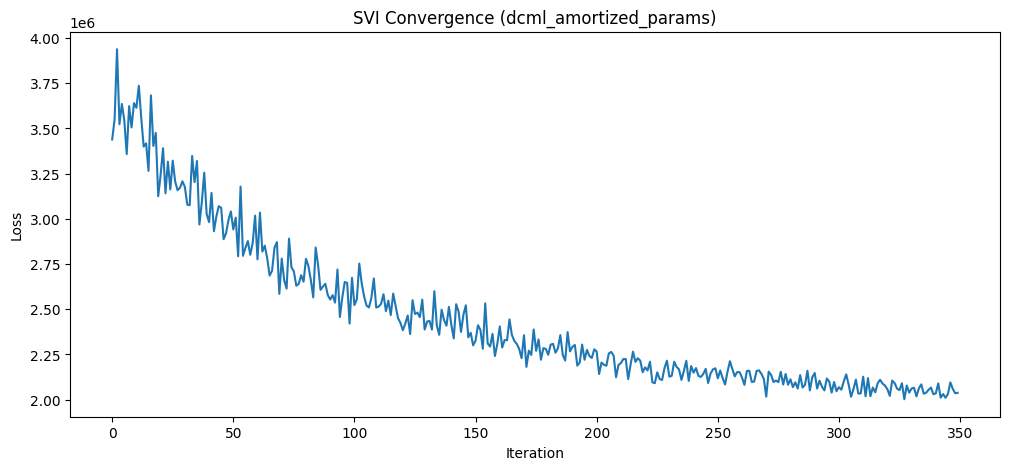

In [18]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=350, lr=0.01, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

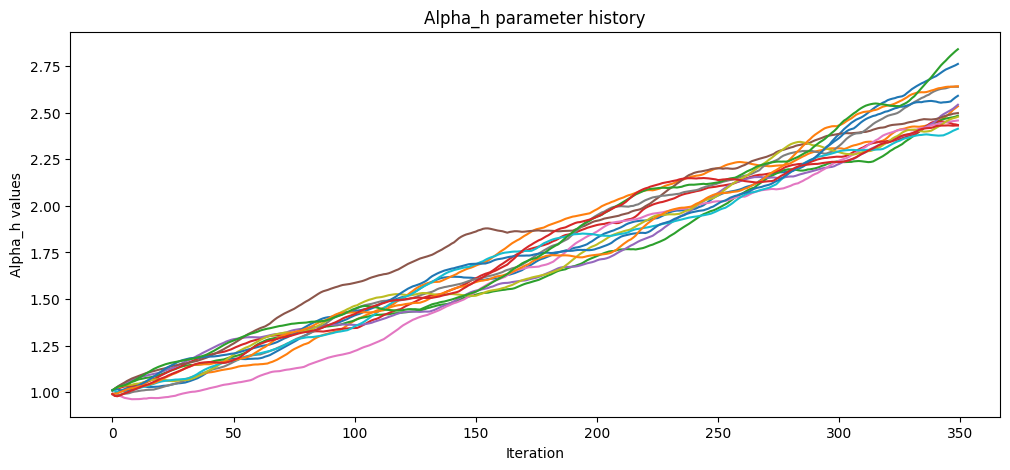

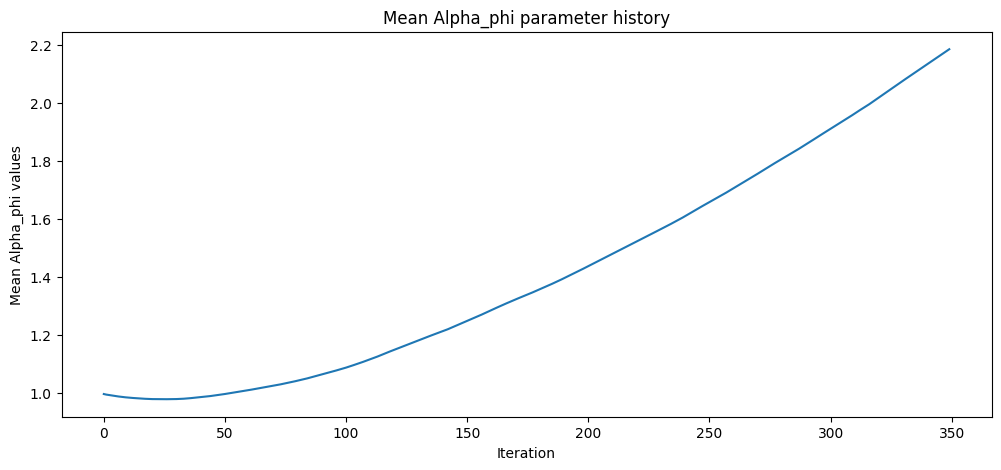

In [19]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

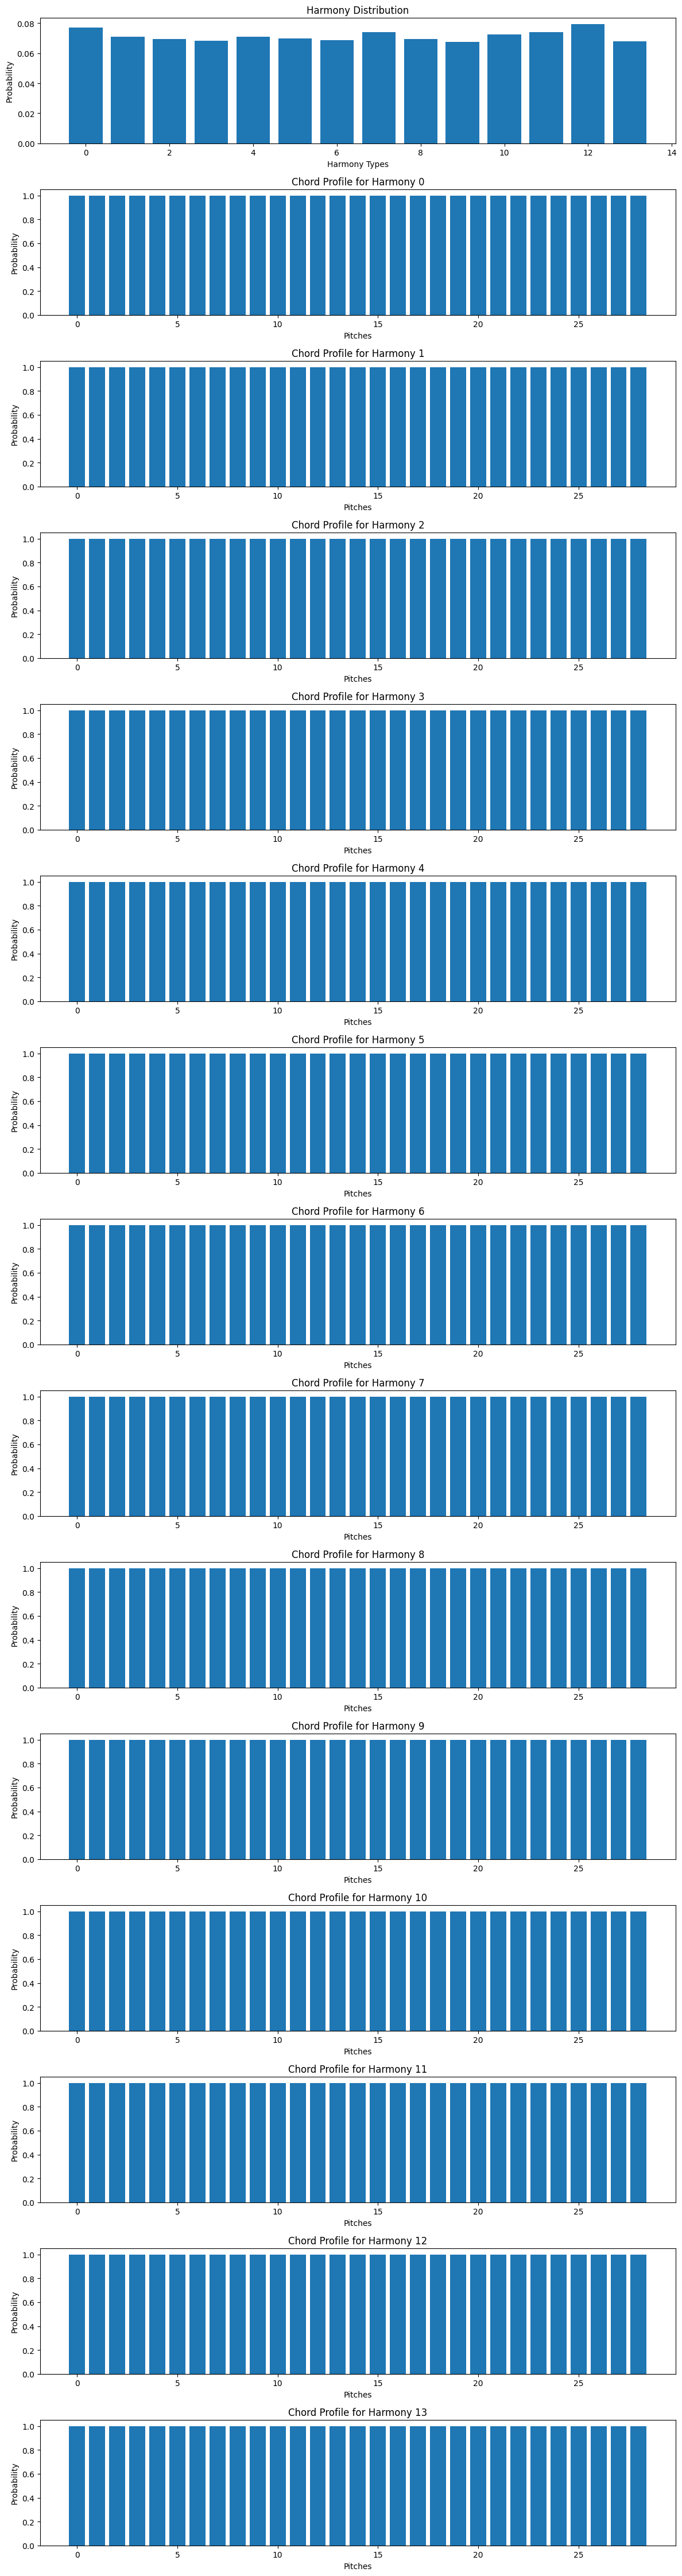

In [20]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")